# Advanced Lane Finding

In [1]:
from IPython.display import HTML

HTML("""
    <h1 style="font-family: sans-serif; padding: 20px 0; text-align: center">Project video</h1>
    <div style="width: 100%">
        <video style="width: inherit" controls autoplay loop src="test_videos/project_video.mp4"/>
    </div>
    """)

### Lane Finder class

In [1]:
from Camera import LaneCamera
from LaneIsolator import LaneIsolator
from SlidingWindowDetector import SlidingWindowDetector
from skimage.draw import polygon
import numpy as np
import cv2

class LaneFinder(object):
    def __init__(self, camera_input, camera_calibration_file=None):
        self.camera = LaneCamera(camera_input)
        self.video_shape = self.camera.get_frame().shape
        self.isolator = LaneIsolator()
        self.detector = SlidingWindowDetector()
        if camera_calibration_file:
            self.camera.load_camera_calibration(camera_calibration_file)
        
    def request_video_frame(self):
        frame = self.camera.get_frame()
        view = self.camera.birds_eye_view(frame)
        lanes_bitmap = self.isolator.isolate_lines(view)
        lane_poly = self.detector.get_lane_poly(lanes_bitmap)
        return (lane_poly, frame)
    
    def get_lane_overlay(self, frame, poly, color=(0, 255, 0)):
        # Turn our poynomials into functions
        p_left = np.poly1d(poly[0])
        p_right = np.poly1d(poly[1])
        
        # Generate y points
        y = np.linspace(0, self.video_shape[0]-1)
        
        # Get x values for each generated y points
        left_x = [p_left(y) for y in y]
        right_x = [p_right(y) for y in y]
        
        # Create an empty image
        img = np.zeros(self.video_shape, dtype=np.uint8)
        
        # Turn our data into usable vertices
        left = np.array(list(zip(y, left_x)))
        right = np.flipud(np.array(list(zip(y, right_x))))
        
        # Concatenate all our vertices into one array
        vertices = np.concatenate((left, right))
        
        # Define a polygon from our vertices
        rr, cc = polygon(vertices[:, 0].clip(0, self.video_shape[0]-1), vertices[:, 1])
        
        # Fill our polygon
        img[rr, cc] = color
        
        # Inverse perspective transform and return
        return self.camera.inverse_birds_eye_view(img)
    
    def get_lane_curvature(self, poly):
        p_left = poly[0]
        p_right = poly[1]
        p_left_m = poly[2]
        p_right_m = poly[3]
        y_val = self.video_shape[1]
        curve_left = self._curvature(y_val, p_left_m[0], p_left_m[1])
        curve_right = self._curvature(y_val, p_right_m[0], p_right_m[1])
        return (curve_left, curve_right)
    
    def _curvature(self, y, A, B):
        R = (1 + (2*A*y + B)**2)**(3/2)
        R = R/np.absolute(2 * A)
        return R

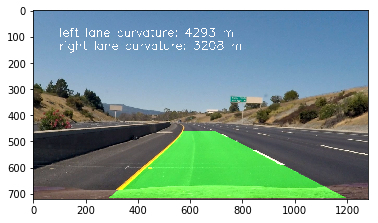

In [19]:
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

lane_finder = LaneFinder("test_videos/project_video.mp4", 
                         "camera_cal/calibration_data.npy")

def process_image(image):
    poly, frame = lane_finder.request_video_frame()
    overlay = lane_finder.get_lane_overlay(frame, poly)
    img = cv2.addWeighted(frame, 1, overlay, 0.6, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane_curvature = lane_finder.get_lane_curvature(poly)
    curvature_str1 = "left lane curvature: {:.0f} m".format(lane_curvature[0])
    curvature_str2 = "right lane curvature: {:.0f} m".format(lane_curvature[1])
    cv2.putText(img, curvature_str1,(100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(img, curvature_str2,(100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    return img

clip = VideoFileClip('test_videos/project_video.mp4')
a_clip = clip.fl_image(process_image)
%time a_clip.write_videofile("output2.mp4", audio=False)

In [4]:
HTML("""
    <h1 style="font-family: sans-serif; padding: 20px 0; text-align: center">Output video</h1>
    <div style="width: 100%">
        <video style="width: inherit" controls autoplay loop src="output2.mp4"/>
    </div>
    """)